In [1]:

# Install dependencies (only needed once in Jupyter)
# !pip install pandas matplotlib pyspark findspark seaborn

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

In [2]:
# Create Spark session
spark = SparkSession.builder.appName("Test").getOrCreate()

# Load dataset
data = spark.read.csv("MIDMARKS.csv", header=True)
data.show()
data.printSchema()

+----+-------+---+----+---+----+---+----+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|
+----+-------+---+----+---+----+---+----+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|
|   9|  ALPHA| 10|  18|  A|  20| 19|  15|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|
|  13|  ALPHA| 16|  18| 11|  15| 19|  15|
|  14|  ALPHA| 17|  17| 18|  11| 15|   9|
|  15|  ALPHA| 19|  20| 20|  20| 18|  12|
|  16|  ALPHA| 13|  18| 17|  19| 16|   9|
|  17|  ALPHA| 15|  17| 18|  17| 17|  13|
|  18|  ALPHA| 11|   8| 18|  15| 19|  15|
|  19|  ALPHA| 14|  12| 16|  16| 20|  14|
|  20|  ALPHA| 19|  17| 20|  20| 20|  18|
+----+-------+---+----+---+----+--

1. All 20 displayed records belong to the ALPHA section only.

2. Subject marks mostly range from 0 to 20, suggesting scores out of 20.

3. Every column is stored as a string, so numeric columns need type conversion for analysis.

4. Row 9 in the PP column contains an “A”, indicating an invalid or missing value.

5. Some students achieved full marks (20) in multiple subjects, while others show very low scores (e.g., M-II = 0), reflecting wide performance variation.

In [3]:
data.groupBy("SECTION").count().show()

+-------+-----+
|SECTION|count|
+-------+-----+
|   GAMA|    1|
|   ZETA|   19|
|   SGMA|    1|
|   NULL|   41|
|   BETA|   60|
|  OMEGA|   60|
|EPSILON|   60|
|  SIGMA|   59|
|  ALPHA|   60|
|  GAMMA|   59|
|  DELTA|   60|
+-------+-----+



In [4]:
from pyspark.sql.functions import when, col, round
data = data.na.fill({"SECTION": "ZETA"})
data = data.withColumn(
    "SECTION",
    when(col("SECTION") == "GAMA", "GAMMA")
    .when(col("SECTION") == "SGMA", "SIGMA")
    .otherwise(col("SECTION"))
)

data.groupBy("SECTION").count().show()

+-------+-----+
|SECTION|count|
+-------+-----+
|   ZETA|   60|
|   BETA|   60|
|  OMEGA|   60|
|EPSILON|   60|
|  SIGMA|   60|
|  ALPHA|   60|
|  GAMMA|   60|
|  DELTA|   60|
+-------+-----+



This PySpark code first fills missing values in the SECTION column with `"ZETA"`.
It then corrects spelling errors by replacing `"GAMA"` with `"GAMMA"` and `"SGMA"` with `"SIGMA"`.
Finally, it groups the data by SECTION and counts the number of records in each category.

In [5]:
data.groupBy("DV").count().show()

+----+-----+
|  DV|count|
+----+-----+
|   7|    6|
|  15|   45|
|  11|   31|
|   3|    1|
|   8|   10|
|  16|   48|
|NULL|    1|
|   5|    8|
|  18|   47|
|  2o|    1|
|  17|   52|
|   6|    9|
|  19|   37|
|   A|    8|
|   9|   14|
|   1|    3|
|  20|   52|
|  10|   22|
|   4|    3|
|  12|   27|
+----+-----+
only showing top 20 rows


In [6]:
data = data.withColumn(
    "DV",
    when(col("DV") == "A","0")
    .when(col("DV") == "2o","20")
    .when(col("DV") == "MP","0")
    .when(col("DV") == "I9","19")
    .otherwise(col("DV"))
)
data = data.na.fill({"DV": "0"})
data.groupBy("DV").count().show()

+---+-----+
| DV|count|
+---+-----+
|  7|    6|
| 15|   45|
| 11|   31|
|  3|    1|
|  8|   10|
| 16|   48|
|  0|   10|
|  5|    8|
| 18|   47|
| 17|   52|
|  6|    9|
| 19|   38|
|  9|   14|
|  1|    3|
| 20|   53|
| 10|   22|
|  4|    3|
| 12|   27|
| 13|   25|
| 14|   24|
+---+-----+
only showing top 20 rows


This code cleans the DV column by correcting specific erroneous entries: "A" and "MP" are replaced with "0", "2o" with "20", and "I9" with "19".
It then fills any remaining missing values in DV with "0".
Finally, it groups the data by DV and shows the count of records for each value.

In [7]:
data.groupBy("M-II").count().show() 

+----+-----+
|M-II|count|
+----+-----+
|   7|   14|
|  15|   24|
|  11|   24|
|   3|   34|
|   8|   29|
|  16|   16|
|   0|   24|
|NULL|    3|
|   5|   23|
|  18|   23|
|  I2|    1|
|  17|   32|
|   6|   18|
|   o|    3|
|  19|   12|
|   A|    4|
|  II|    1|
|  AB|    5|
|   9|   17|
|   1|   16|
+----+-----+
only showing top 20 rows


In [8]:
data = data.withColumn(
    "M-II",
    when(col("M-II") == "A","0")
    .when(col("M-II") == "I2","12")
    .when(col("M-II") == "o","0")
    .when(col("M-II") == "II","11")
    .when(col("M-II") == "AB","0")
    .when(col("M-II") == "I","1")
    .otherwise(col("M-II"))
)
data = data.na.fill({"M-II": "0"})
data.groupBy("M-II").count().show()

+----+-----+
|M-II|count|
+----+-----+
|   7|   14|
|  15|   24|
|  11|   25|
|   3|   34|
|   8|   29|
|  16|   16|
|   0|   39|
|   5|   23|
|  18|   23|
|  17|   32|
|   6|   18|
|  19|   12|
|   9|   17|
|   1|   18|
|  20|   44|
|  10|   19|
|   4|   22|
|  12|   24|
|  13|   18|
|  14|   17|
+----+-----+
only showing top 20 rows


This code cleans the M-II column by correcting specific incorrect entries: for example, "A", "o", and "AB" are replaced with "0", "I2" with "12", "II" with "11", and "I" with "1".
It fills any remaining missing values in M-II with "0".
Finally, it groups the data by M-II and displays the count of records for each value.

In [9]:
data.groupBy("PP").count().show()

+---+-----+
| PP|count|
+---+-----+
|  7|   10|
| 15|   26|
| 11|   28|
|  3|   13|
|  8|   12|
| 16|   28|
|  0|    3|
|  5|   15|
| 18|   35|
| 17|   31|
|  6|   18|
| 19|   35|
|  A|    8|
| AB|    3|
|  9|   24|
|  1|    7|
| 20|   70|
| 10|   19|
|  4|   10|
| 12|   28|
+---+-----+
only showing top 20 rows


In [10]:
data = data.withColumn(
    "PP",
    when(col("PP") == "A","0")
    .when(col("PP") == "AB","0")
    .when(col("PP") == "MP","0")
    .otherwise(col("PP"))
)
data.groupBy("PP").count().show()

+---+-----+
| PP|count|
+---+-----+
|  7|   10|
| 15|   26|
| 11|   28|
|  3|   13|
|  8|   12|
| 16|   28|
|  0|   15|
|  5|   15|
| 18|   35|
| 17|   31|
|  6|   18|
| 19|   35|
|  9|   24|
|  1|    7|
| 20|   70|
| 10|   19|
|  4|   10|
| 12|   28|
| 13|   15|
| 14|   28|
+---+-----+
only showing top 20 rows


This code cleans the PP column by replacing "A", "AB", and "MP" with "0".
It does not fill missing values explicitly, so any remaining nulls remain unchanged.
Finally, it groups the data by PP and displays the count of records for each value.

In [11]:
data.groupBy("BEEE").count().show()

+----+-----+
|BEEE|count|
+----+-----+
|   7|   15|
|  15|   28|
|  11|   31|
|   3|   14|
|   8|   13|
|  16|   23|
|   0|    1|
|NULL|    2|
|   5|   10|
|  18|   30|
|  17|   45|
|  Ab|    1|
|   6|   14|
|   o|    1|
|  19|   41|
|   A|   15|
|   9|   19|
|   1|    3|
|  20|   76|
|  10|   20|
+----+-----+
only showing top 20 rows


In [12]:
data = data.withColumn(
    "BEEE",
    when(col("BEEE") == "A","0")
    .when(col("BEEE") == "Ab","0")
    .when(col("BEEE") == "o","0")
    .when(col("BEEE") == "I7","17")
    .otherwise(col("BEEE"))
)
data = data.na.fill({"BEEE": "0"})
data.groupBy("BEEE").count().show()

+----+-----+
|BEEE|count|
+----+-----+
|   7|   15|
|  15|   28|
|  11|   31|
|   3|   14|
|   8|   13|
|  16|   23|
|   0|   20|
|   5|   10|
|  18|   30|
|  17|   46|
|   6|   14|
|  19|   41|
|   9|   19|
|   1|    3|
|  20|   76|
|  10|   20|
|   4|   12|
|  12|   21|
|  13|   14|
|  14|   21|
+----+-----+
only showing top 20 rows


This code cleans the BEEE column by correcting specific erroneous entries: "A", "Ab", and "o" are replaced with "0", and "I7" is replaced with "17".
It then fills any remaining missing values in BEEE with "0".
Finally, it groups the data by BEEE and shows the count of records for each value.

In [13]:
data.groupBy("FL").count().show()

+----+-----+
|  FL|count|
+----+-----+
|   7|    2|
|  15|   85|
|  11|   10|
|   8|    6|
|  16|   15|
|NULL|    1|
|  18|   58|
|  2o|    1|
|  17|    9|
|   6|    2|
|  19|   34|
|   A|   10|
|  AB|    1|
|   9|    3|
|  20|  120|
|  10|   55|
|  12|    7|
|  13|   50|
|  14|   11|
+----+-----+



In [14]:
data = data.withColumn(
    "FL",
    when(col("FL") == "A","0")
    .when(col("FL") == "Ab","0")
    .when(col("FL") == "AB","0")
    .when(col("FL") == "2o","20")
    .otherwise(col("FL"))
)
data = data.na.fill({"FL": "0"})
data.groupBy("FL").count().show()

+---+-----+
| FL|count|
+---+-----+
|  7|    2|
| 15|   85|
| 11|   10|
|  8|    6|
| 16|   15|
|  0|   12|
| 18|   58|
| 17|    9|
|  6|    2|
| 19|   34|
|  9|    3|
| 20|  121|
| 10|   55|
| 12|    7|
| 13|   50|
| 14|   11|
+---+-----+



This code cleans the FL column by correcting specific entries: "A", "Ab", and "AB" are replaced with "0", while "2o" is corrected to "20".
It then fills any remaining missing values in FL with "0".
Finally, it groups the data by FL and displays the count of records for each value.

In [15]:
data.groupBy("FIMS").count().show()

+----+-----+
|FIMS|count|
+----+-----+
|   7|    5|
|  15|   57|
|  11|   22|
|   3|    6|
|   8|   11|
|  16|   49|
|   0|    1|
|   5|    5|
|  18|   62|
|  17|   40|
|   6|    5|
|  19|   34|
|   A|    7|
|  Io|    1|
|  AB|    9|
|   9|   28|
|   1|    3|
|  20|   12|
|  10|   18|
|   4|    5|
+----+-----+
only showing top 20 rows


In [16]:
data = data.withColumn(
    "FIMS",
    when(col("FIMS") == "A","0")
    .when(col("FIMS") == "AB","0")
    .when(col("FIMS") == "Io","10")
    .when(col("FIMS") == "I9","19")
    .otherwise(col("FIMS"))
)
data.groupBy("FIMS").count().show()

+----+-----+
|FIMS|count|
+----+-----+
|   7|    5|
|  15|   57|
|  11|   22|
|   3|    6|
|   8|   11|
|  16|   49|
|   0|   17|
|   5|    5|
|  18|   62|
|  17|   40|
|   6|    5|
|  19|   35|
|   9|   28|
|   1|    3|
|  20|   12|
|  10|   19|
|   4|    5|
|  12|   20|
|  13|   36|
|  14|   40|
+----+-----+
only showing top 20 rows


This code cleans the FIMS column by correcting specific entries: "A" and "AB" are replaced with "0", "Io" is corrected to "10", and "I9" is corrected to "19".
It does not explicitly fill missing values, so any remaining nulls remain as-is.
Finally, it groups the data by FIMS and displays the count of records for each value.

In [17]:
data.show()

+----+-------+---+----+---+----+---+----+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|
+----+-------+---+----+---+----+---+----+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|
|   9|  ALPHA| 10|  18|  0|  20| 19|  15|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|
|  13|  ALPHA| 16|  18| 11|  15| 19|  15|
|  14|  ALPHA| 17|  17| 18|  11| 15|   9|
|  15|  ALPHA| 19|  20| 20|  20| 18|  12|
|  16|  ALPHA| 13|  18| 17|  19| 16|   9|
|  17|  ALPHA| 15|  17| 18|  17| 17|  13|
|  18|  ALPHA| 11|   8| 18|  15| 19|  15|
|  19|  ALPHA| 14|  12| 16|  16| 20|  14|
|  20|  ALPHA| 19|  17| 20|  20| 20|  18|
+----+-------+---+----+---+----+--

# CALCULATIONS

In [18]:
data = data.withColumn(
    "Total",
    col("DV").cast("int") + col("M-II").cast("int") + col("PP").cast("int") + col("BEEE").cast("int") + col("FIMS").cast("int") + col("FL").cast("int")
)

data.show()

+----+-------+---+----+---+----+---+----+-----+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|Total|
+----+-------+---+----+---+----+---+----+-----+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|   72|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|   84|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|  102|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|   94|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|  111|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|   85|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|   94|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|  105|
|   9|  ALPHA| 10|  18|  0|  20| 19|  15|   82|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|  112|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|  111|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|  115|
|  13|  ALPHA| 16|  18| 11|  15| 19|  15|   94|
|  14|  ALPHA| 17|  17| 18|  11| 15|   9|   87|
|  15|  ALPHA| 19|  20| 20|  20| 18|  12|  109|
|  16|  ALPHA| 13|  18| 17|  19| 16|   9|   92|
|  17|  ALPHA| 15|  17| 18|  17| 17|  13|   97|
|  18|  ALPHA| 11|   8| 18|  15| 19|  15

This code creates a new column Total by summing the integer values of all subject columns: DV, M-II, PP, BEEE, FIMS, and FL.
It ensures that each column is cast to integer before summing to avoid data type issues.
Finally, it displays the updated DataFrame with the newly calculated Total column.

In [19]:
data = data.withColumn(
    "Percentage",
    round(
        (
            col("DV").cast("int") + 
            col("M-II").cast("int") + 
            col("PP").cast("int") + 
            col("BEEE").cast("int") + 
            col("FIMS").cast("int") + 
            col("FL").cast("int") 
        )/120 *100 , 2
    )
)

data.show()

+----+-------+---+----+---+----+---+----+-----+----------+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|Total|Percentage|
+----+-------+---+----+---+----+---+----+-----+----------+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|   72|      60.0|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|   84|      70.0|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|  102|      85.0|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|   94|     78.33|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|  111|      92.5|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|   85|     70.83|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|   94|     78.33|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|  105|      87.5|
|   9|  ALPHA| 10|  18|  0|  20| 19|  15|   82|     68.33|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|  112|     93.33|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|  111|      92.5|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|  115|     95.83|
|  13|  ALPHA| 16|  18| 11|  15| 19|  15|   94|     78.33|
|  14|  ALPHA| 17|  17| 18|  11| 15|   9|   87|      72.

This code calculates the Percentage for each student by summing all subject marks (DV, M-II, PP, BEEE, FIMS, FL), dividing by the total marks 120, and multiplying by 100.
The result is rounded to 2 decimal places for clarity.
Finally, it displays the DataFrame with the newly calculated Percentage column.

In [20]:
data = data.withColumn(
    "Grade",
    when(col("Percentage") >= 90,"A+")
    .when(col("Percentage") >= 80,"A")
    .when(col("Percentage") >= 70,"B+")
    .when(col("Percentage") >= 60,"B")
    .when(col("Percentage") >= 50,"C")
    .otherwise("F")
)
data.show()

+----+-------+---+----+---+----+---+----+-----+----------+-----+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|Total|Percentage|Grade|
+----+-------+---+----+---+----+---+----+-----+----------+-----+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|   72|      60.0|    B|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|   84|      70.0|   B+|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|  102|      85.0|    A|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|   94|     78.33|   B+|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|  111|      92.5|   A+|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|   85|     70.83|   B+|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|   94|     78.33|   B+|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|  105|      87.5|    A|
|   9|  ALPHA| 10|  18|  0|  20| 19|  15|   82|     68.33|    B|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|  112|     93.33|   A+|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|  111|      92.5|   A+|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|  115|     95.83|   A+|
|  13|  ALPHA| 16|  18| 1

This code assigns a Grade to each student based on their Percentage using standard thresholds: A+ for ≥90, A for ≥80, B+ for ≥70, B for ≥60, C for ≥50, and F for anything below 50.
It uses PySpark’s when and otherwise functions to apply these conditions.
Finally, it displays the DataFrame with the newly assigned Grade column.

# SKILLS CHECK

In [21]:
data = data.withColumn(
    "Programming Skills",
    when(col("PP") >= 18,"Excellent")
    .when(col("PP") >= 15,"Good")
    .otherwise("Poor")
)
data.show()

+----+-------+---+----+---+----+---+----+-----+----------+-----+------------------+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|Total|Percentage|Grade|Programming Skills|
+----+-------+---+----+---+----+---+----+-----+----------+-----+------------------+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|   72|      60.0|    B|              Good|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|   84|      70.0|   B+|              Good|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|  102|      85.0|    A|         Excellent|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|   94|     78.33|   B+|         Excellent|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|  111|      92.5|   A+|         Excellent|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|   85|     70.83|   B+|         Excellent|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|   94|     78.33|   B+|         Excellent|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|  105|      87.5|    A|         Excellent|
|   9|  ALPHA| 10|  18|  0|  20| 19|  15|   82|     68.33|    B|            

This code evaluates Programming Skills based on the PP marks: students scoring ≥18 are labeled "Excellent", those with ≥15 as "Good", and the rest as "Poor".
It uses PySpark’s when and otherwise functions to apply these conditions.
Finally, it displays the DataFrame with the newly created Programming Skills column.

In [22]:
data = data.withColumn(
    "DV Skills",
    when(col("DV") >= 18,"Excellent")
    .when(col("DV") >= 15,"Good")
    .otherwise("Poor")
)
data.show()

+----+-------+---+----+---+----+---+----+-----+----------+-----+------------------+---------+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|Total|Percentage|Grade|Programming Skills|DV Skills|
+----+-------+---+----+---+----+---+----+-----+----------+-----+------------------+---------+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|   72|      60.0|    B|              Good|     Poor|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|   84|      70.0|   B+|              Good|Excellent|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|  102|      85.0|    A|         Excellent|Excellent|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|   94|     78.33|   B+|         Excellent|     Good|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|  111|      92.5|   A+|         Excellent|Excellent|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|   85|     70.83|   B+|         Excellent|     Good|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|   94|     78.33|   B+|         Excellent|     Good|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|  105|      87.5|  

This code evaluates DV Skills based on the DV marks: students scoring ≥18 are labeled "Excellent", those with ≥15 as "Good", and the rest as "Poor".
It uses PySpark’s when and otherwise functions to apply these conditions.
Finally, it displays the DataFrame with the newly created DV Skills column.

In [23]:
df = data.toPandas()

This PySpark code converts the `data` DataFrame from a PySpark DataFrame to a Pandas DataFrame and stores it in `df`. This allows using Pandas functions for further analysis.


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S.NO                480 non-null    object 
 1   SECTION             480 non-null    object 
 2   DV                  480 non-null    object 
 3   M-II                480 non-null    object 
 4   PP                  480 non-null    object 
 5   BEEE                480 non-null    object 
 6   FL                  480 non-null    object 
 7   FIMS                480 non-null    object 
 8   Total               480 non-null    int32  
 9   Percentage          480 non-null    float64
 10  Grade               480 non-null    object 
 11  Programming Skills  480 non-null    object 
 12  DV Skills           480 non-null    object 
dtypes: float64(1), int32(1), object(11)
memory usage: 47.0+ KB


In [25]:
df['DV'] = pd.to_numeric(df['DV'], errors='coerce')
df['M-II'] = pd.to_numeric(df['M-II'], errors='coerce')
df['PP'] = pd.to_numeric(df['PP'], errors='coerce')
df['BEEE'] = pd.to_numeric(df['BEEE'], errors='coerce')
df['FL'] = pd.to_numeric(df['FL'], errors='coerce')
df['FIMS'] = pd.to_numeric(df['FIMS'], errors='coerce')

This code converts the columns DV, M-II, PP, BEEE, FL, and FIMS to numeric types using pd.to_numeric.
Any non-numeric or invalid entries in these columns are coerced to NaN.
This ensures that all subject columns are in a consistent numeric format for further calculations.

In [26]:
df['Backlogs']=0
for i in range(len(df)):
    count=0
    if df['DV'][i]<10:
        count+=1
    if df['M-II'][i]<10:
        count+=1
    if df['PP'][i]<10:
        count+=1
    if df['BEEE'][i]<10:
        count+=1
    if df['FL'][i]<10:
        count+=1
    if df['FIMS'][i]<10:
        count+=1
    df['Backlogs'][i]=count
df

,S.NO,SECTION,DV,M-II,PP,BEEE,FL,FIMS,Total,Percentage,Grade,Programming Skills,DV Skills,Backlogs
0,1,ALPHA,12,0,17,9,19,15,72,60.00,B,Good,Poor,2
1,2,ALPHA,19,12,16,16,18,3,84,70.00,B+,Good,Excellent,1
2,3,ALPHA,18,14,18,18,18,16,102,85.00,A,Excellent,Excellent,0
3,4,ALPHA,15,9,19,17,19,15,94,78.33,B+,Excellent,Good,1
4,5,ALPHA,18,17,19,19,20,18,111,92.50,A+,Excellent,Excellent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,476,ZETA,18,2,12,3,17,15,67,55.83,C,Poor,Excellent,2
476,477,ZETA,20,6,16,11,20,14,87,72.50,B+,Good,Excellent,1
477,478,ZETA,20,0,18,13,20,18,89,74.17,B+,Excellent,Excellent,1
478,479,ZETA,20,20,5,19,18,14,96,80.00,A,Poor,Excellent,1


This code creates a new column Backlogs to count the number of subjects in which a student scored less than 10.
It iterates through each row and increments the count for every subject (DV, M-II, PP, BEEE, FL, FIMS) with marks below 10.
Finally, it assigns this count to the Backlogs column for each student, showing how many subjects they are failing.

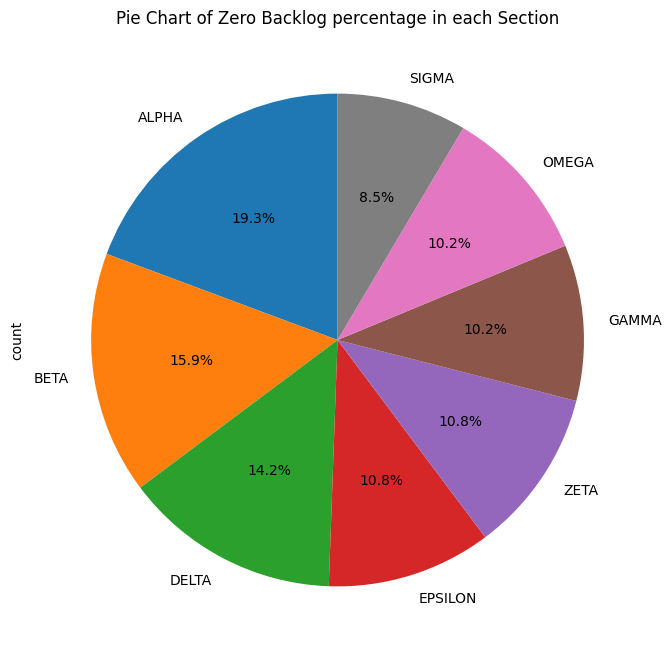

In [27]:
b = df.loc[(df['Backlogs']<1)]
a = b['SECTION'].value_counts()
a.plot(kind = 'pie', figsize = (8, 8), autopct = '%1.1f%%', startangle = 90)
plt.title("Pie Chart of Zero Backlog percentage in each Section")
plt.show()

This code filters the students who have zero backlogs `(Backlogs < 1)` and counts how many are in each SECTION.
It then plots a pie chart showing the percentage distribution of students with zero backlogs across all sections.
The chart includes percentages on the slices and starts at a 90° angle, with a title "Pie Chart of Zero Backlog percentage in each Section".

The `Zero Backlog Percentage` is very less in `SIGMA`, `GAMMA` and `OMEGA`. Those Sections need to be improved.

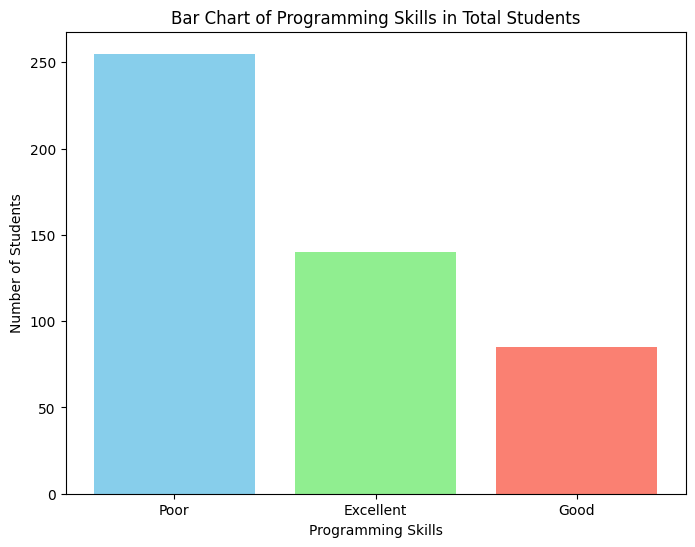

In [28]:
a = df['Programming Skills'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(a.index, a.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel("Programming Skills")
plt.ylabel("Number of Students")
plt.title("Bar Chart of Programming Skills in Total Students")
plt.show()

This code counts the number of students in each Programming Skills category.
It then plots a bar chart showing these counts, with different colors for each category.
The chart includes labeled axes and a title "Bar Chart of Programming Skills in Total Students".

The Students are very Poor when it comes to Programming. For those students who are poor in Programming Skills must attend a remedial Session conducted by the Institution.

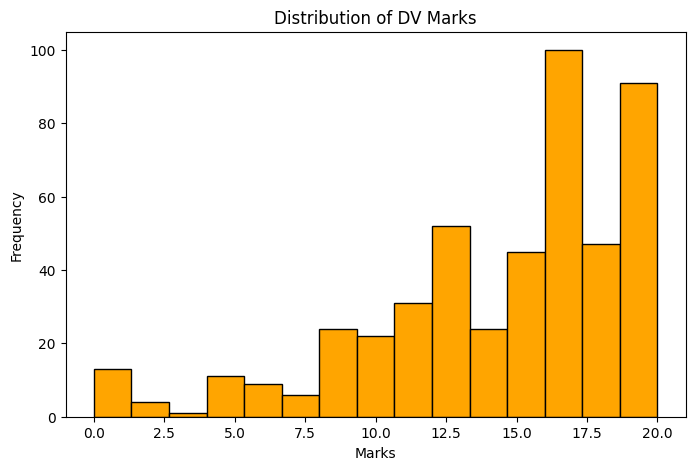

In [29]:
plt.figure(figsize=(8,5))
plt.hist(df["DV"].astype(int), bins=15, color="orange", edgecolor="black")
plt.title("Distribution of DV Marks")
plt.xlabel("Marks")
plt.ylabel("Frequency")
plt.show()


This Pandas/Matplotlib code plots a histogram of `DV` marks from `df`, showing their distribution. The histogram has 15 bins, purple bars with black edges, and labeled axes. The plot is titled "Distribution of DV Marks".

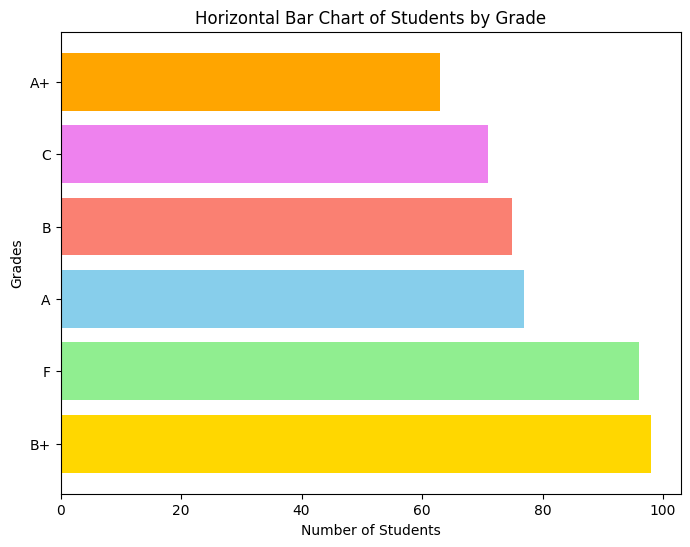

In [30]:
counts = df["Grade"].value_counts()
plt.figure(figsize=(8,6))
plt.barh(counts.index, counts.values, color=['gold', 'lightgreen', 'skyblue', 'salmon', 'violet', 'orange'])
plt.xlabel("Number of Students")
plt.ylabel("Grades")
plt.title("Horizontal Bar Chart of Students by Grade")
plt.show()

This code counts the number of students in each Grade category.
It then plots a horizontal bar chart showing the distribution of students across grades.
The chart includes labeled axes and a title "Horizontal Bar Chart of Students by Grade".
 `90+` of the students are `Failed` and `60+` of the Students have `Topped` the `Exams`.

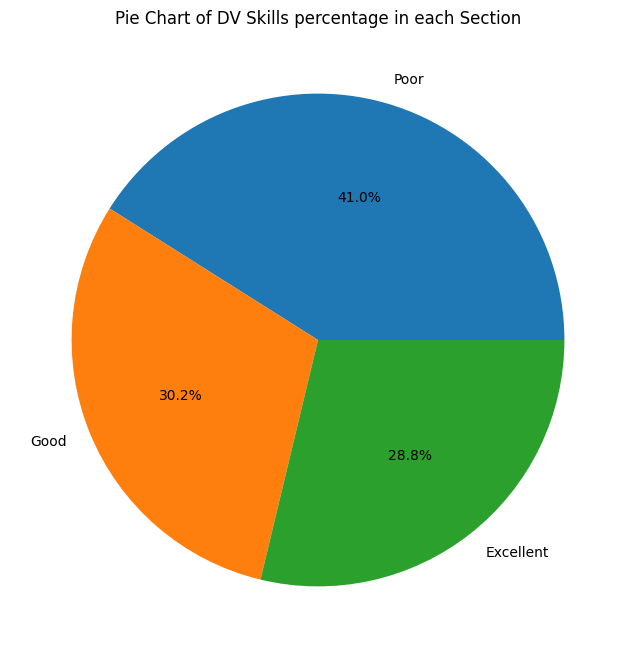

In [31]:
counts = df["DV Skills"].value_counts()
plt.figure( figsize = (8, 8))
plt.pie(counts, labels=counts.index, autopct="%1.1f%%")
plt.title("Pie Chart of DV Skills percentage in each Section")
plt.show()

This code counts the number of students in each DV Skills category.
It then plots a pie chart showing the distribution of students across these skill levels with different colors.
The chart includes labeled axes and a title "Pie Chart of DV Skills in Total Students".

The Students are very Weak when it comes to Data Visualization over `41.0%` are `poor` in `DV Skills`. Those students Who are weak in DV Skills must attend a remedial Session conducted by the Department

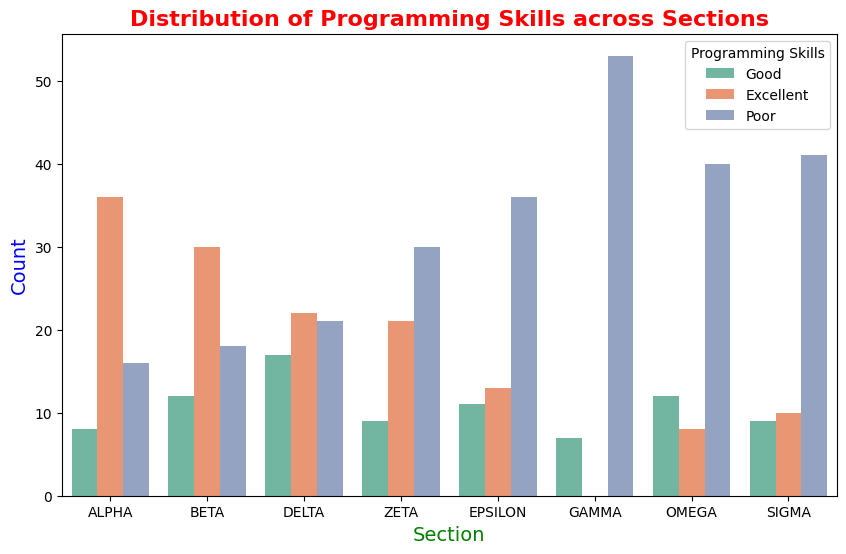

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(x='SECTION', hue='Programming Skills', data=df, palette="Set2", dodge=True)
plt.title("Distribution of Programming Skills across Sections",fontsize=16,weight='bold',color='red')
plt.xlabel("Section",fontsize=14,color='green')
plt.ylabel("Count",fontsize=14,color='blue')
plt.show()

This code creates a grouped count plot to show the distribution of Programming Skills across different SECTIONS. It highlights how many students in each section fall into the "Poor," "Good," or "Excellent" categories, allowing for easy comparison.

The GAMMA section stands out as needing improvement, as it has the largest number of students classified as "Poor."

Sections such as OMEGA, SIGMA, and GAMMA would benefit most from additional support or remedial programs, given their high numbers of "Poor" and "Good" performers.

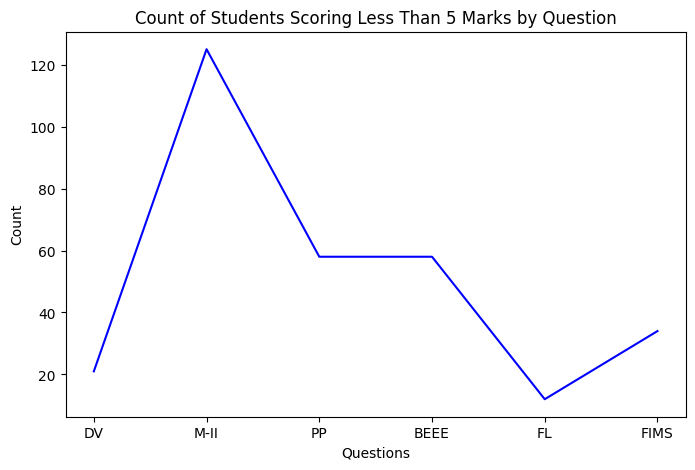

In [33]:
less_marks_count = (df[['DV', 'M-II', 'PP', 'BEEE', 'FL', 'FIMS']] < 5).sum()

plt.figure(figsize=(8, 5))
sns.lineplot(x=less_marks_count.index, y=less_marks_count.values, color='blue')

plt.title("Count of Students Scoring Less Than 5 Marks by Question")
plt.xlabel("Questions")
plt.ylabel("Count")
plt.show()


This code computes the number of students scoring below 5 in each subject (DV, M-II, PP, BEEE, FL, FIMS) and visualizes the results as a line chart. The x-axis represents the subjects, the y-axis shows the count of students, and the chart is titled "Count of Students Scoring Less Than 5 Marks by Question".

Among the subjects, M-II has the highest number of students with low scores, while FL has the fewest students scoring below 5.

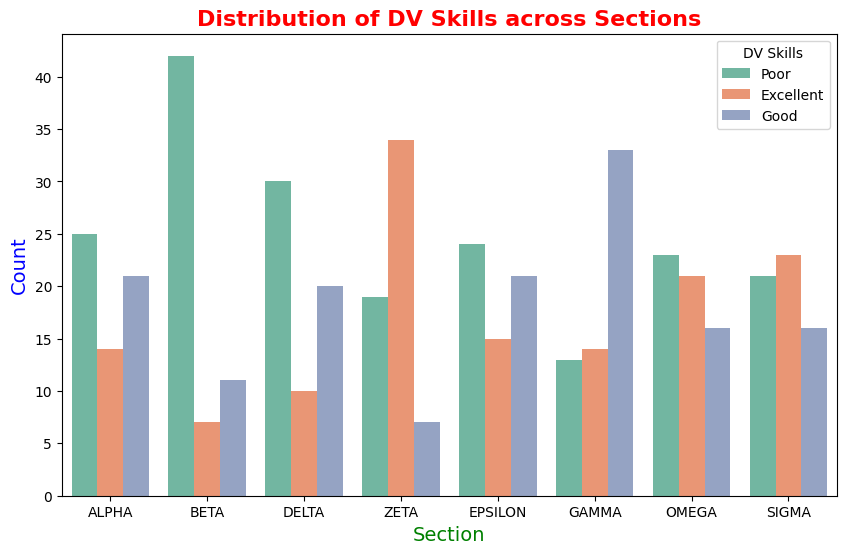

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(x='SECTION', hue='DV Skills', data=df, palette="Set2", dodge=True)
plt.title("Distribution of DV Skills across Sections", fontsize=16, weight='bold', color='red')
plt.xlabel("Section", fontsize=14, color='green')
plt.ylabel("Count", fontsize=14, color='blue')
plt.show()


This code creates a grouped count plot to show the distribution of DV Skills across different SECTIONS. It highlights the number of students in each section classified as "Poor," "Good," or "Excellent," allowing for easy comparison.

The ALPHA section requires improvement, as it has the largest number of students in the "Poor" category.

Sections like ALPHA, BETA, and GAMMA would benefit most from remedial programs, given their high numbers of "Poor" and "Average" performers.

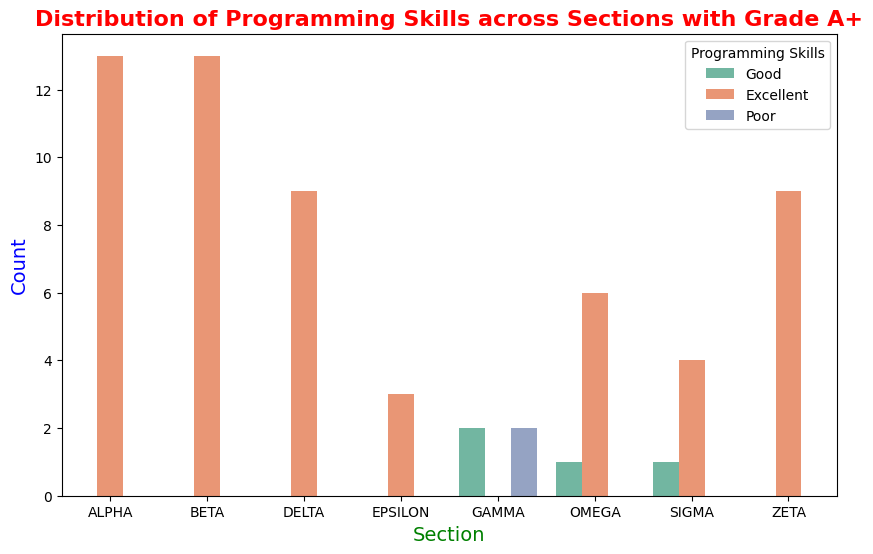

In [35]:
a = df[df["Grade"]=="A+"]
b = a["SECTION"]

plt.figure(figsize=(10,6))
sns.countplot(x=b, hue="Programming Skills", data=df, palette="Set2", dodge=True)
plt.title("Distribution of Programming Skills across Sections with Grade A+",fontsize=16,weight='bold',color='red')
plt.xlabel("Section",fontsize=14,color='green')
plt.ylabel("Count",fontsize=14,color='blue')
plt.show()

# `Conclusion` : -
`GAMMA`, `SIGMA` and `OMEGA` `SECTIONS` needs more attention by the faculty over more Students have many Backlogs. So, the Management must focus on them to conduct some sessions so that they can clear the Backlogs quickly for the Students Who have more Backlogs from the `GAMMA` , `SIGMA` and `OMEGA` Sections.